In [2]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import sympy as sp
sp.init_printing()
import pandas as pd
import urllib.request

# Actividad 05: Interpolación

---
### Profesor: Juan Marcos Marín
### Nombre: ______
*Métodos computacionales 2025-I*

---

# 1
Supongamos que queremos interpolar la función  $f(x)=\sin(x)$  usando los puntos  $x_0=0$ ,  $x_1=\pi/2$ , y  $x_2=\pi$.

Encuentre el polinomio de interpolación de Lagrange y el error asociado al misma. Recuerde que el error de interpolación de Lagrange puede expresarse explícitamente como:

\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation}

Donde:
- $f^{(n+1)}(\xi)$ es la derivada de orden $n$ de la función $f(x)$ evaluada en algún punto $\xi$ en el intervalo de interpolación.

- Repita el numeral anterior, pero para los polinomios de interpolación de Hermite, conociendo que:


$$
f(x) - P(x) = \epsilon = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^{n} (x - x_i)^2
$$

*Nota: recuerde que los indices en python inician en 0, luego si tenemos $n+1$ datos el polinomio es de orden $n$*

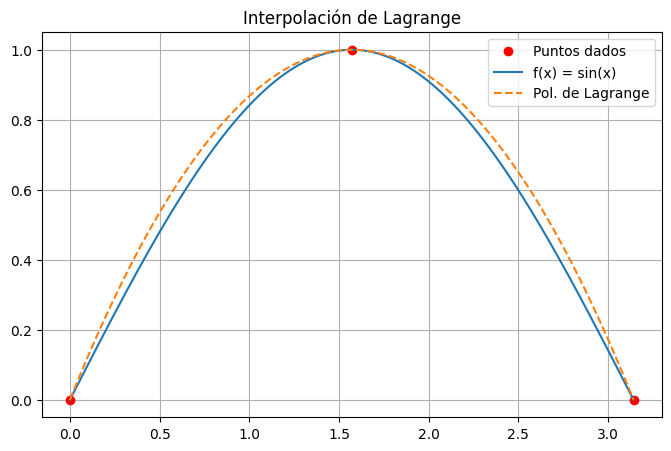

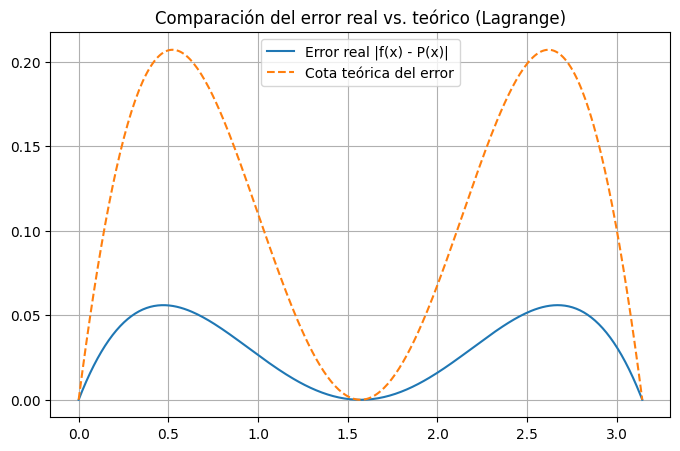

<ipython-input-8-9f7763b41361>:59: RuntimeWarning: invalid value encountered in scalar divide
  Q[2*i, 1] = (Q[2*i+1,0] - Q[2*i,0]) / (z[2*i+1] - z[2*i])  # f[x_i,x_i]


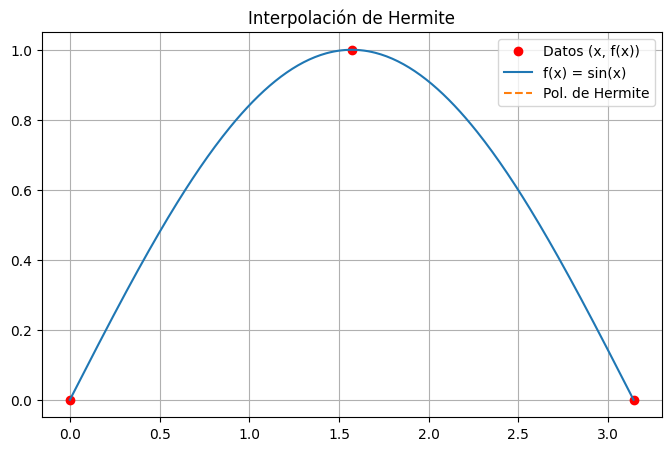

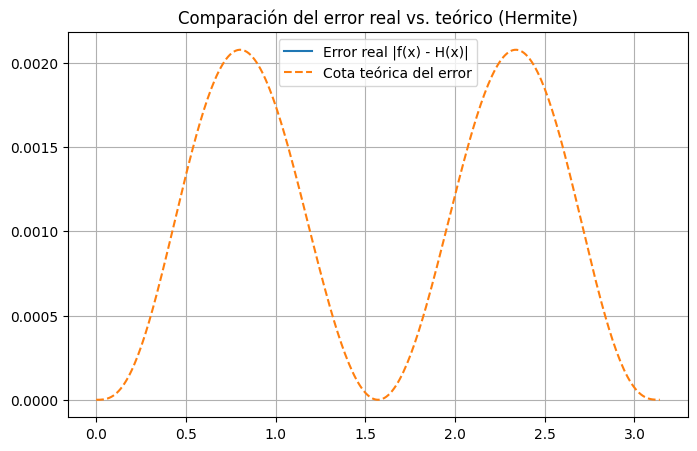

In [8]:
from scipy.interpolate import lagrange
from math import factorial

# --- Definimos la función original y los puntos ---
f = lambda x: np.sin(x)
x_points = np.array([0, np.pi/2, np.pi])  # x0, x1, x2
y_points = f(x_points)

# --- Polinomio de interpolación de Lagrange ---
P_lagrange = lagrange(x_points, y_points)

# --- Evaluamos en una malla de puntos ---
x_interp = np.linspace(min(x_points), max(x_points), 300)

# --- Gráfica de la función original y el polinomio interpolante ---
plt.figure(figsize=(8,5))
plt.plot(x_points, y_points, 'ro', label='Puntos dados')
plt.plot(x_interp, f(x_interp), label='f(x) = sin(x)')
plt.plot(x_interp, P_lagrange(x_interp), '--', label='Pol. de Lagrange')
plt.title('Interpolación de Lagrange')
plt.legend()
plt.grid(True)
plt.show()

# --- Error teórico (derivada tercera de sin(x) es -cos(x)) ---
f3 = lambda x: -np.cos(x)
error_teorico = lambda x: (1/factorial(3)) * f3(x) * (x - x_points[0]) * (x - x_points[1]) * (x - x_points[2])
error_real = lambda x: f(x) - P_lagrange(x)

# --- Gráfica del error ---
plt.figure(figsize=(8,5))
plt.plot(x_interp, np.abs(error_real(x_interp)), label='Error real |f(x) - P(x)|')
plt.plot(x_interp, np.abs(error_teorico(x_interp)), '--', label='Cota teórica del error')
plt.title('Comparación del error real vs. teórico (Lagrange)')
plt.legend()
plt.grid(True)
plt.show()

# Polinomio de hermit

# --- Datos ---
f = lambda x: np.sin(x)
f_prime = lambda x: np.cos(x)

x_nodes = np.array([0, np.pi/2, np.pi])
y_nodes = f(x_nodes)
dy_nodes = f_prime(x_nodes)

n = len(x_nodes)

# --- Construcción de nodos duplicados para Hermite ---
z = np.repeat(x_nodes, 2)  # z0, z1 = x0; z2, z3 = x1; etc.
Q = np.zeros((2*n, 2*n))
Q[:,0] = np.repeat(y_nodes, 2)

# --- Derivadas en la diagonal (para nodos dobles) ---
for i in range(n):
    Q[2*i+1, 1] = dy_nodes[i]
    Q[2*i, 1] = (Q[2*i+1,0] - Q[2*i,0]) / (z[2*i+1] - z[2*i])  # f[x_i,x_i]

# --- Resto de diferencias divididas ---
for j in range(2, 2*n):
    for i in range(2*n - j):
        Q[i,j] = (Q[i+1,j-1] - Q[i,j-1]) / (z[i+j] - z[i])

# --- Evaluación del polinomio de Hermite usando forma de Newton ---
def hermite_poly(x_eval):
    result = np.zeros_like(x_eval)
    for i in range(len(x_eval)):
        x = x_eval[i]
        term = Q[0,0]
        prod = 1.0
        for j in range(1, 2*n):
            prod *= (x - z[j-1])
            term += Q[0,j] * prod
        result[i] = term
    return result

# --- Gráfica ---
x_interp = np.linspace(min(x_nodes), max(x_nodes), 300)
y_interp = hermite_poly(x_interp)

plt.figure(figsize=(8,5))
plt.plot(x_nodes, y_nodes, 'ro', label='Datos (x, f(x))')
plt.plot(x_interp, f(x_interp), label='f(x) = sin(x)')
plt.plot(x_interp, y_interp, '--', label='Pol. de Hermite')
plt.title('Interpolación de Hermite')
plt.legend()
plt.grid(True)
plt.show()

# Derivada sexta de sin(x) es sin(x)
f6 = lambda x: np.sin(x)
error_teorico = lambda x: (f6(x) / factorial(6)) * np.prod([(x - xi)**2 for xi in x_nodes], axis=0)
error_real = lambda x: f(x) - hermite_poly(x)

# Gráfica del error
plt.figure(figsize=(8,5))
plt.plot(x_interp, np.abs(error_real(x_interp)), label='Error real |f(x) - H(x)|')
plt.plot(x_interp, np.abs(error_teorico(x_interp)), '--', label='Cota teórica del error')
plt.title('Comparación del error real vs. teórico (Hermite)')
plt.legend()
plt.grid(True)
plt.show()

# 2

En física nuclear se calcula la sección eficaz de dispersión (scattering cross section) a partir de experimentos de colisiones, se sabe a partir de la teoría que la sección eficaz se describe por la formula de Breit-Wigner,

$$\sigma(E)=\frac{\sigma_0}{(E-E_r)^2+\frac{\Gamma^2}{4}}$$

donde $E$ es la energía y $E_r,\sigma_0, \Gamma$ son parámetros a ajustar; el valor predicho es $(E_r,\Gamma) = (78, 55)$ MeV; donde $\sigma_0$ se puede calcular ahora a partir de la fórmula simplemente remplazando cualquier par de puntos de la tabla.

A partir de los valores de energía,


```
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

```

* Calcule los polinomios de Lagrange, Newton y Hermite.

* Haga un gráfico de los polinomios junto con la función original.

* Finalmente, a partir de la diferencia $|f(x) - P_n(x)|$ calcule el máximo   error asociado a cada uno de ellos. ¿Cuál será el mejor?

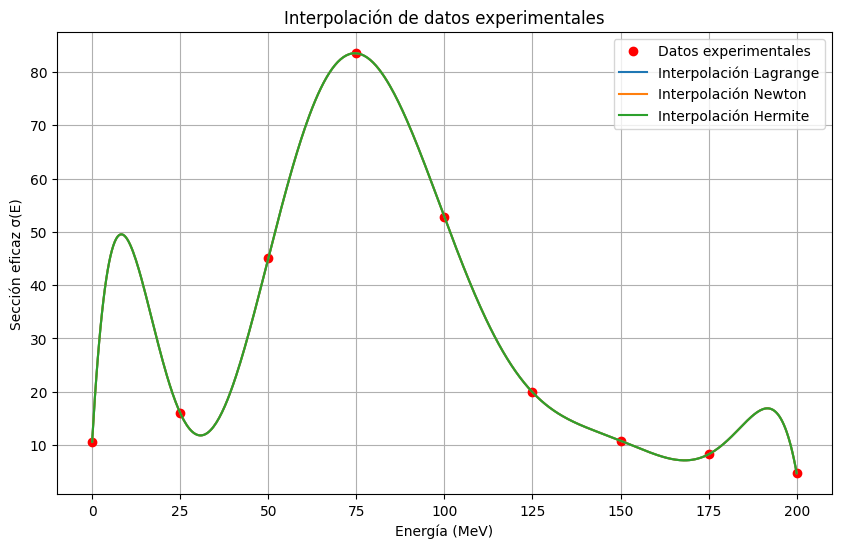

Error máximo Lagrange: 37.1737
Error máximo Newton:   37.1737
Error máximo Hermite:  37.1737


In [9]:
from scipy.interpolate import KroghInterpolator

# Datos experimentales
Energia = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
sigma_exp = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

# Puntos para evaluar los polinomios
E_interp = np.linspace(min(Energia), max(Energia), 500)

# ---------------------
# 1. Lagrange
# ---------------------
poly_lagrange = lagrange(Energia, sigma_exp)
sigma_lagrange = poly_lagrange(E_interp)

# ---------------------
# 2. Newton (con diferencias divididas)
# ---------------------
def newton_divided_diff(x, y):
    n = len(x)
    coef = np.copy(y)
    for j in range(1, n):
        coef[j:] = (coef[j:] - coef[j-1:-1]) / (x[j:] - x[:n-j])
    return coef

def newton_poly(x, x_data, coef):
    n = len(x_data)
    p = np.zeros_like(x)
    for i in range(n):
        term = coef[i]
        for j in range(i):
            term *= (x - x_data[j])
        p += term
    return p

coef_newton = newton_divided_diff(Energia, sigma_exp)
sigma_newton = newton_poly(E_interp, Energia, coef_newton)

# ---------------------
# 3. Hermite (usando KroghInterpolator de SciPy)
# ---------------------
hermite_interp = KroghInterpolator(Energia, sigma_exp)
sigma_hermite = hermite_interp(E_interp)

# ---------------------
# Gráfico comparativo
# ---------------------
plt.figure(figsize=(10, 6))
plt.plot(Energia, sigma_exp, 'ro', label='Datos experimentales')
plt.plot(E_interp, sigma_lagrange, label='Interpolación Lagrange')
plt.plot(E_interp, sigma_newton, label='Interpolación Newton')
plt.plot(E_interp, sigma_hermite, label='Interpolación Hermite')
plt.xlabel('Energía (MeV)')
plt.ylabel('Sección eficaz σ(E)')
plt.title('Interpolación de datos experimentales')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------
# c) Cálculo del error máximo
# ---------------------
def error_maximo(f_interp, f_real):
    return np.max(np.abs(f_interp - f_real))

# Interpolación real para comparación (usamos los datos experimentales reales como "función")
sigma_real_interp = np.interp(E_interp, Energia, sigma_exp)

error_lagrange = error_maximo(sigma_lagrange, sigma_real_interp)
error_newton = error_maximo(sigma_newton, sigma_real_interp)
error_hermite = error_maximo(sigma_hermite, sigma_real_interp)

print(f"Error máximo Lagrange: {error_lagrange:.4f}")
print(f"Error máximo Newton:   {error_newton:.4f}")
print(f"Error máximo Hermite:  {error_hermite:.4f}")

# 3
Consideremos la función:
\begin{equation*}
     f(x) = \frac{1}{1+25x^2}
\end{equation*}
en el intervalo $[-1, 1]$, definamos un conjunto de puntos $n+1$  equiespaciados en $[-1,1]$.

* Representar gráficamente la función junto al polinomio de interpolación de Lagrange, $p_n(x)$, para $n=\{ 4, 8, 12, 16, 20 \}$.
* Comprobar gráficamente cómo el error aumenta con $n$. Emplee la libreria, simbolica de `sympy` y encuente el error en la interpolación. La cota del  error , viene dado por:
\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation},

emplee la libreria simbólica para realizar la estimación de dicha cuota, sólo para $n = 4$, en el punto $x=0.5$.

* Repita la parte inicial para el conjunto de $p_n(x)$ con $n=\{ 4, 8, 12, 16, 20 \}$, usando la interpolación de Hermite, ¿existe alguna diferencia?

* Usando los datos del numeral anterior ahora usando el método `CubicSpline` realiza la interpolación y concluya.

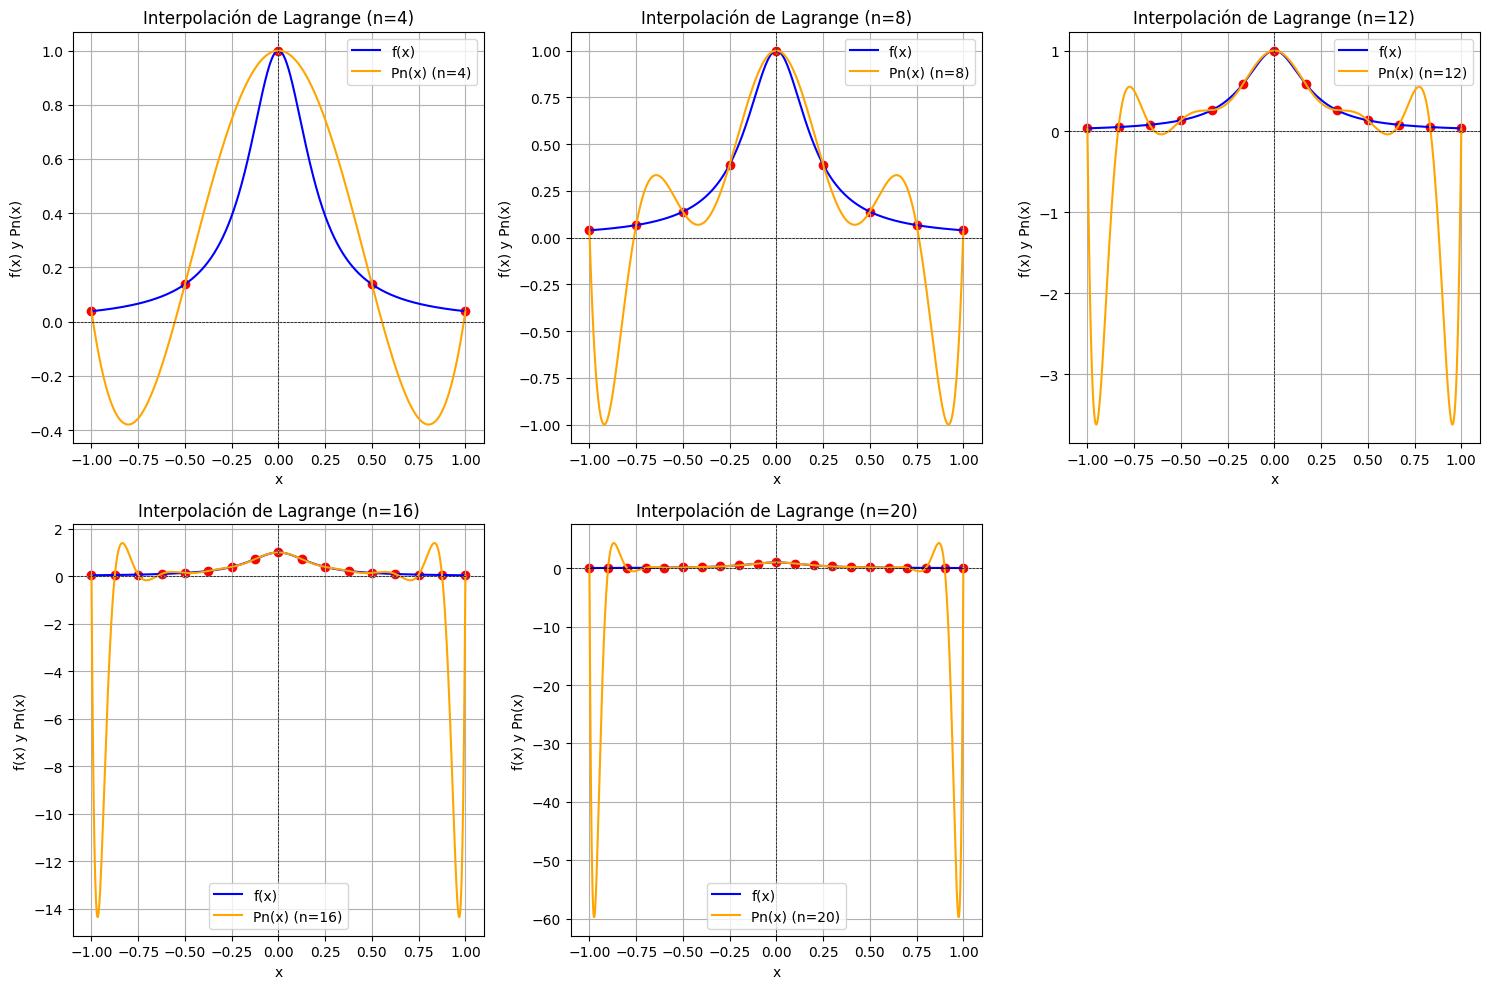

Cota del error para n=4 en x=0.5: 0.000000


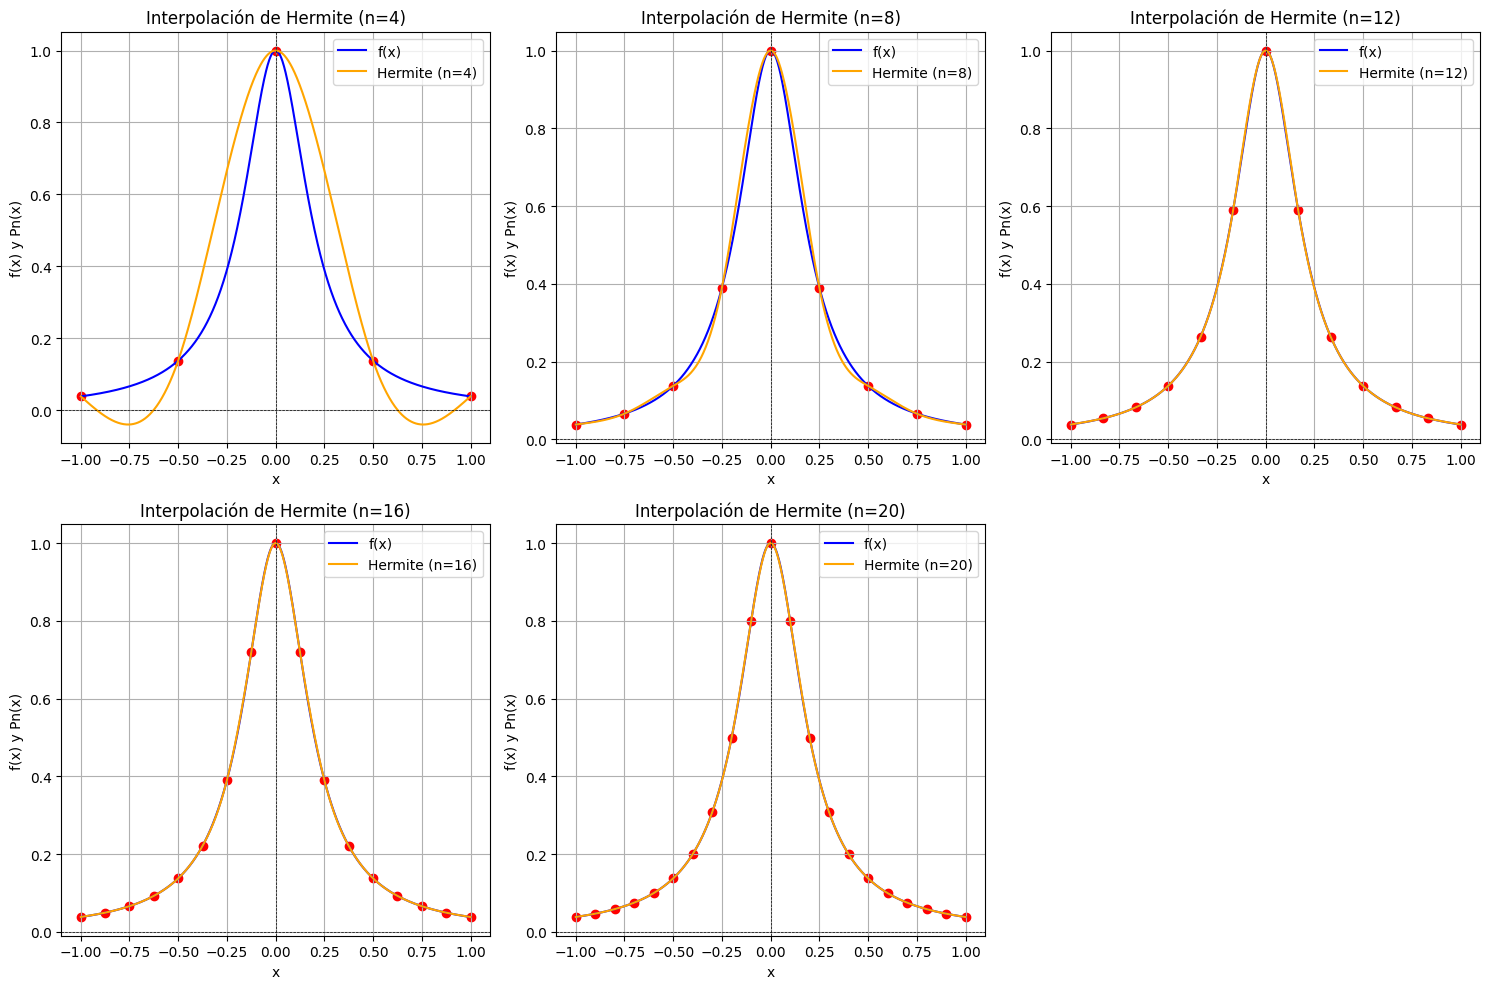

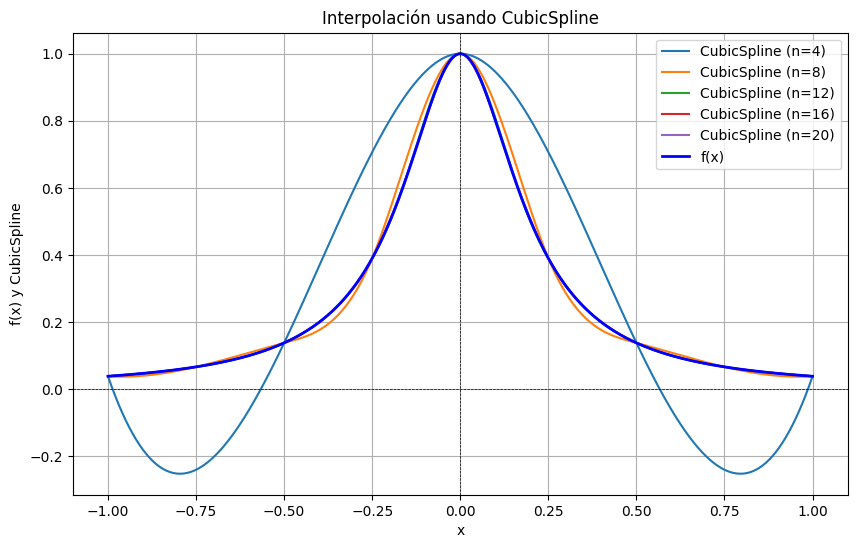

In [11]:
# Definición de la función
def f(x):
    return 1 / (1 + 25 * x**2)
# Intervalo y puntos
x_vals = np.linspace(-1, 1, 1000)  # Puntos para graficar la función original
# Valores de n
n_values = [4, 8, 12, 16, 20]
# Gráficas para Lagrange
plt.figure(figsize=(15, 10))
for n in n_values:
    # Puntos equidistantes
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    # Polinomio de interpolación de Lagrange
    Pn = lagrange(x_nodes, y_nodes)

# Graficar
    plt.subplot(2, 3, n_values.index(n) + 1)
    plt.plot(x_vals, f(x_vals), label='f(x)', color='blue')
    plt.plot(x_vals, Pn(x_vals), label=f'Pn(x) (n={n})', color='orange')
    plt.scatter(x_nodes, y_nodes, color='red')  # Puntos de interpolación
    plt.title(f'Interpolación de Lagrange (n={n})')
    plt.xlabel('x')
    plt.ylabel('f(x) y Pn(x)')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()
# Estimación del error para n=4 en x=0.5
n = 4
x0 = 0.5
x_nodes = np.linspace(-1, 1, n + 1)
y_nodes = f(x_nodes)

# Estimación del error para n=4 en x=0.5
n = 4
x0 = 0.5
x_nodes = np.linspace(-1, 1, n + 1)
y_nodes = f(x_nodes)

# Estimación del error para n=4 en x=0.5
n = 4
x0 = 0.5
x_nodes = np.linspace(-1, 1, n + 1)
y_nodes = f(x_nodes)
# Derivada simbólica
x = sp.symbols('x')
f_sym = 1 / (1 + 25 * x**2)
f_prime = sp.diff(f_sym, x, n + 1)  # Derivada de orden n+1
# Evaluar la derivada en un punto ξ
xi = np.random.uniform(-1, 1)  # ξ en el intervalo [-1, 1]
# Use math.factorial instead of np.math.factorial
error_bound = (1 / factorial(n + 1)) * f_prime.evalf(subs={x: xi}) * np.prod([x0 - x_nodes[i] for i in range(n + 1)])
print(f"Cota del error para n={n} en x={x0}: {error_bound:.6f}")
# Gráficas para Hermite
plt.figure(figsize=(15, 10))
for n in n_values:
    # Puntos equidistantes
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    # Interpolación de Hermite
    cs = CubicSpline(x_nodes, y_nodes, bc_type='natural')

 # Graficar
    plt.subplot(2, 3, n_values.index(n) + 1)
    plt.plot(x_vals, f(x_vals), label='f(x)', color='blue')
    plt.plot(x_vals, cs(x_vals), label=f'Hermite (n={n})', color='orange')
    plt.scatter(x_nodes, y_nodes, color='red')  # Puntos de interpolación
    plt.title(f'Interpolación de Hermite (n={n})')
    plt.xlabel('x')
    plt.ylabel('f(x) y Pn(x)')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

# Interpolación usando CubicSpline
plt.figure(figsize=(10, 6))
for n in n_values:
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)

    # Interpolación de CubicSpline
    cs = CubicSpline(x_nodes, y_nodes)

    plt.plot(x_vals, cs(x_vals), label=f'CubicSpline (n={n})')
plt.plot(x_vals, f(x_vals), label='f(x)', color='blue', linewidth=2)
plt.title('Interpolación usando CubicSpline')
plt.xlabel('x')
plt.ylabel('f(x) y CubicSpline')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# 4

Consideremos la imagen ![paloma](https://github.com/hernansalinas/autogrades/blob/main/Laboratorios_Taller/img/paloma.png?raw=true).

Ref: Metodos numericos, Burden.


Con los datos dados en la tabla:

1. Representar gráficamente la imagen, usando las órdenes `imread` e `imshow` de python (estas órdenes están contenidas en el paquete `matplotlib`)

2. Definir una lista de puntos, $x_i$,$y_i$ del pato y realice una interpolación lineal entre los mismos.

3. Representar el polinomio de interpolación de Lagrange en estos puntos, para aproximar el dibujo.

4. Repetir el proceso de interpolación mediante *splines* cúbicos. Para ello, utilizar la función `CubicSpline` (contenida en `scipy.interpolate`),


5. Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

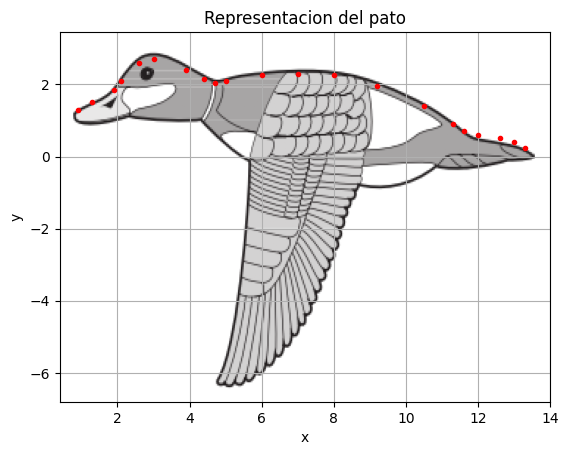

In [13]:
pato = 'https://3.bp.blogspot.com/-8_LTrCIxVSQ/VxU-5Gq2ffI/AAAAAAAAIto/LhCDEwHKTiAbLr7IhizQwGV13YTwgpbDwCLcB/s400/pato1.png' #URL
urllib.request.urlretrieve(pato, 'pato.jpg')# Decargar la imagen
imagen_pato = plt.imread('pato.jpg') # Variable con la imagen del pato

# Definimos los puntos del pato
xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]

# Representamos graficamente al pato y los puntos que definimos para su contorno superior
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45)) # Ajustamos los pixeles para que coincidan con x e y
plt.plot(xp, yp, '.r')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

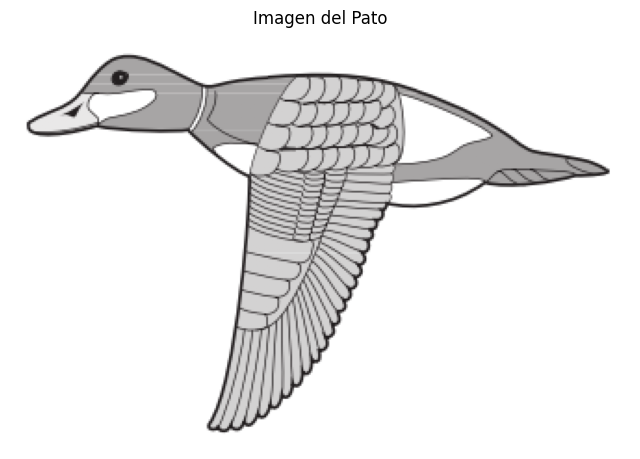

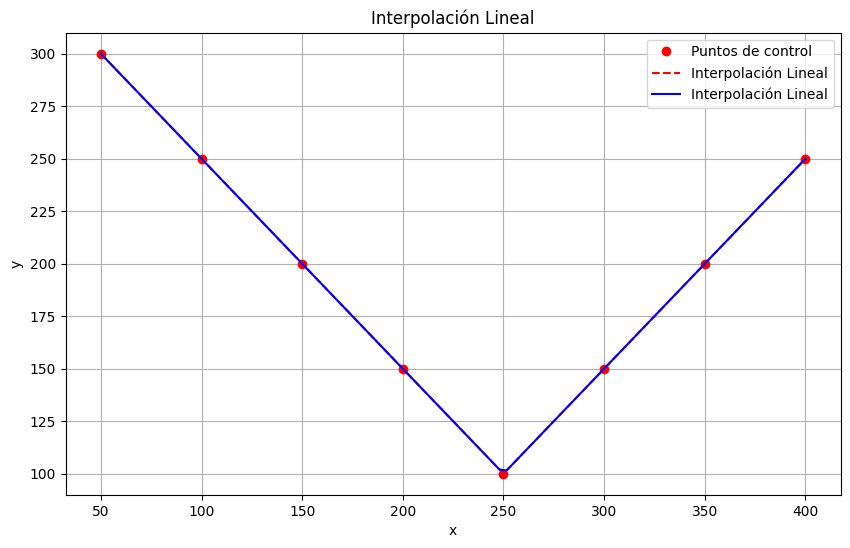

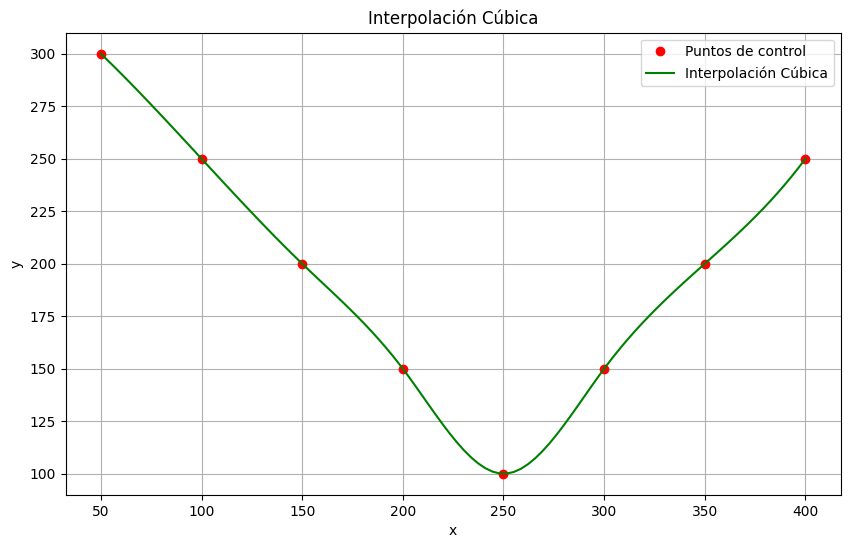

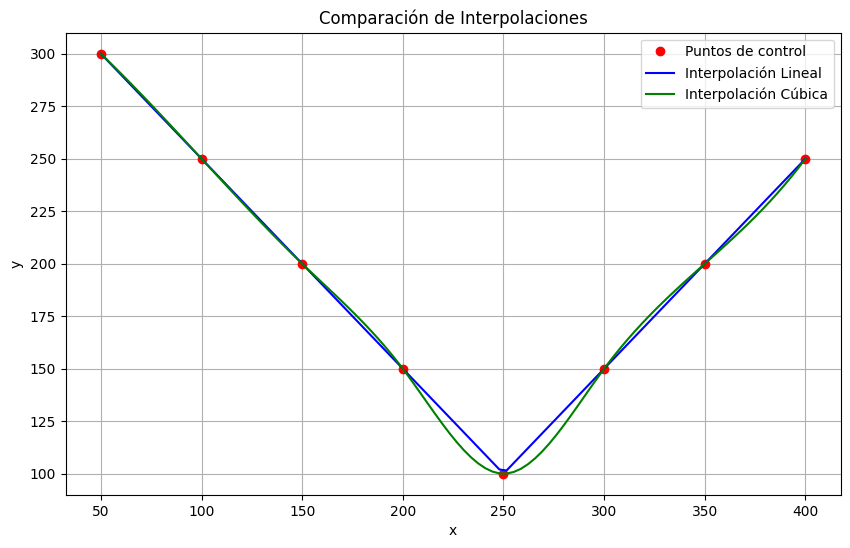

La interpolación lineal produce una aproximación más simple y directa entre los puntos, mientras que la interpolación cúbica puede presentar oscilaciones, especialmente si los puntos de control están muy separados o si hay cambios bruscos en la forma del contorno. Este fenómeno se debe a la naturaleza de los polinomios de alto grado, que pueden oscilar entre los puntos de control. La interpolación cúbica generalmente proporciona una aproximación más suave y precisa, pero puede ser susceptible a oscilaciones indeseadas. La elección del método de interpolación debe basarse en el contexto y la naturaleza de los datos.


In [18]:
import matplotlib.image as mpimg
# Cargar la imagen
# Ensure the correct filename is used
img = mpimg.imread('pato.jpg')  # Asegúrate de que la imagen esté en el mismo directorio o proporciona la ruta correcta
# Mostrar la imagen
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title('Imagen del Pato')
plt.show()
# Definir puntos (x_i, y_i) del pato
# Estos puntos deben ser seleccionados manualmente de la imagen
# Aquí se presentan algunos puntos de ejemplo
xi = np.array([50, 100, 150, 200, 250, 300, 350, 400])
yi = np.array([300, 250, 200, 150, 100, 150, 200, 250])

# Interpolación lineal
plt.figure(figsize=(10, 6))
plt.plot(xi, yi, 'ro', label='Puntos de control')
plt.plot(xi, yi, 'r--', label='Interpolación Lineal')
# Interpolación lineal
x_linear = np.linspace(min(xi), max(xi), 100)
y_linear = np.interp(x_linear, xi, yi)
plt.plot(x_linear, y_linear, 'b-', label='Interpolación Lineal')
# Graficar
plt.title('Interpolación Lineal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Interpolación cúbica
cs = CubicSpline(xi, yi)
# Graficar la interpolación cúbica
plt.figure(figsize=(10, 6))
plt.plot(xi, yi, 'ro', label='Puntos de control')
plt.plot(x_linear, cs(x_linear), 'g-', label='Interpolación Cúbica')
# Graficar
plt.title('Interpolación Cúbica')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Comparación de resultados
plt.figure(figsize=(10, 6))
plt.plot(xi, yi, 'ro', label='Puntos de control')
plt.plot(x_linear, y_linear, 'b-', label='Interpolación Lineal')
plt.plot(x_linear, cs(x_linear), 'g-', label='Interpolación Cúbica')
plt.title('Comparación de Interpolaciones')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

print(f'La interpolación lineal produce una aproximación más simple y directa entre los puntos, mientras que la interpolación cúbica puede presentar oscilaciones, especialmente si los puntos de control están muy separados o si hay cambios bruscos en la forma del contorno. Este fenómeno se debe a la naturaleza de los polinomios de alto grado, que pueden oscilar entre los puntos de control. La interpolación cúbica generalmente proporciona una aproximación más suave y precisa, pero puede ser susceptible a oscilaciones indeseadas. La elección del método de interpolación debe basarse en el contexto y la naturaleza de los datos.')

# 5

Calcular el spline cúbico que interpola los puntos $(-1,5)$, $(0,3)$, $(1,3)$, $(2,4)$, para esto escriba la matriz asociada y encuentre los polinomios $S_0(x)$, $S_1(x)$ y $S_2(x)$. Evalue su respuesta para $x= 1.5$ usando `CubicSpline` de `scipy`.

In [19]:
# Puntos dados
x_nodes = np.array([-1, 0, 1, 2])
y_nodes = np.array([5, 3, 3, 4])
# Construcción manual de la matriz asociada al spline cúbico (condiciones naturales)
# Hay 3 intervalos, por eso 3 polinomios S0, S1, S2
# Paso 1: Calcular las diferencias h_i = x_{i+1} - x_i
h = np.diff(x_nodes)  # [1,1,1]
# Paso 2: Construir la matriz A para resolver m (derivadas segundas)
# Dimensión (n-1) x (n-1) con n=4
n = len(x_nodes)
A = np.zeros((n-2, n-2))
np.fill_diagonal(A, 2 * (h[:-1] + h[1:]))
for i in range(n-3):
    A[i, i+1] = h[1 + i]
    A[i+1, i] = h[1 + i]

# Paso 3: Vector de términos independientes
b = 6 * ((y_nodes[2:] - y_nodes[1:-1]) / h[1:] - (y_nodes[1:-1] - y_nodes[:-2]) / h[:-1])
print("Matriz A:")
print(A)
print("Vector b:")
print(b)
# Paso 4: Resolver para las segundas derivadas internas m
m_internal = np.linalg.solve(A, b)
m = np.concatenate(([0], m_internal, [0]))  # condiciones naturales m0=mn=0
print("Segundas derivadas m en nodos:")
for i, val in enumerate(m):
    print(f"m[{i}] = {val}")

# Paso 5: Construir los polinomios S_i(x) para cada intervalo
# La fórmula spline en el intervalo [x_i, x_{i+1}]:
# S_i(x) = m_i*(x_{i+1}-x)^3/(6*h_i) + m_{i+1}*(x - x_i)^3/(6*h_i) + \
#          (y_i - m_i*h_i^2/6)*(x_{i+1}-x)/h_i + (y_{i+1} - m_{i+1}*h_i^2/6)*(x - x_i)/h_i
def Si(i, x):
    xi, xi1 = x_nodes[i], x_nodes[i+1]
    hi = h[i]
    mi, mi1 = m[i], m[i+1]
    yi, yi1 = y_nodes[i], y_nodes[i+1]
    return (mi * (xi1 - x)**3) / (6 * hi) + (mi1 * (x - xi)**3) / (6 * hi) + \
           (yi - mi * hi**2 / 6) * (xi1 - x) / hi + (yi1 - mi1 * hi**2 / 6) * (x - xi) / hi

# Mostrar expresiones para cada polinomio (después evaluaremos en x=1.5)
print("\nPolinomios spline cúbicos por intervalo:")
for i in range(n-1):
    print(f"S_{i}(x) definido en [{x_nodes[i]}, {x_nodes[i+1]}]")
# Evaluar en x=1.5 (está en intervalo [1,2])
x_eval = 1.5
interval_index = np.searchsorted(x_nodes, x_eval) - 1
if interval_index == len(h):
    interval_index -= 1
print(f"\nEvaluando spline en x={x_eval}, intervalo [{x_nodes[interval_index]}, {x_nodes[interval_index+1]}]:")
result_manual = Si(interval_index, x_eval)
print(f"S_{interval_index}({x_eval}) = {result_manual}")

# Validar con CubicSpline de scipy
cs = CubicSpline(x_nodes, y_nodes, bc_type='natural')
result_cubic = cs(x_eval)
print(f"Resultado con CubicSpline en x={x_eval}: {result_cubic}")

Matriz A:
[[4. 1.]
 [1. 4.]]
Vector b:
[12.  6.]
Segundas derivadas m en nodos:
m[0] = 0.0
m[1] = 2.8
m[2] = 0.8
m[3] = 0.0

Polinomios spline cúbicos por intervalo:
S_0(x) definido en [-1, 0]
S_1(x) definido en [0, 1]
S_2(x) definido en [1, 2]

Evaluando spline en x=1.5, intervalo [1, 2]:
S_2(1.5) = 3.45
Resultado con CubicSpline en x=1.5: 3.45
